In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [2]:
# Install Kaggle API
!pip install kaggle

In [8]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khushit2103","key":"366b7a741b8c347cfd6d0181ce83242f"}'}

In [13]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [14]:
!ls -lh

total 8.0K
-rw-r--r-- 1 root root   67 Oct  3 16:39 'kaggle (1).json'
drwxr-xr-x 1 root root 4.0K Oct  2 13:36  sample_data


In [15]:
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
# Download IMBD dataset

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.56GB/s]


In [17]:
!unzip -q imdb-dataset-of-50k-movie-reviews.zip

In [18]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [19]:
# Load Dataset

df = pd.read_csv('IMDB Dataset.csv')
print(df.head())
print(df["sentiment"].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [20]:
# Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
  text = text.lower()
  text = re.sub(r'<.*?>', '', text)    # Remove HTML tags
  text = re.sub(r'[^a-z\s]', '', text) # Keep only letters
  text = " ".join([word for word in text.split() if word not in stop_words])
  return text

df['review'] = df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
# Tokenization and Padding

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])

X = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(X, maxlen=max_len)

y = np.where(df['sentiment'] == "positive",1,0)

In [23]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Build LSTM Model

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None,max_len))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 200, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,461,057 (5.57 MB)

 Trainable params: 1,461,057 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train Model
history = model.fit(X_train,y_train, validation_split=0.2, epochs=10, batch_size=128)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7472 - loss: 0.4851 - val_accuracy: 0.8597 - val_loss: 0.3308
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9175 - loss: 0.2165 - val_accuracy: 0.8776 - val_loss: 0.3200
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9461 - loss: 0.1498 - val_accuracy: 0.8654 - val_loss: 0.3525
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9622 - loss: 0.1087 - val_accuracy: 0.8622 - val_loss: 0.3994
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9774 - loss: 0.0708 - val_accuracy: 0.8609 - val_loss: 0.4637
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9824 - loss: 0.0558 - val_accuracy: 0.8533 - val_loss: 0.5378
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9760 - loss: 0.0697 - val_accuracy: 0.8580 - val_loss: 0.5397
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9866 - loss: 0.0403 - val_ac

In [31]:
# Evaluate Model

loss,acc = model.evaluate(X_test,y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8440 - loss: 0.6976
Test Accuracy: 85.03%


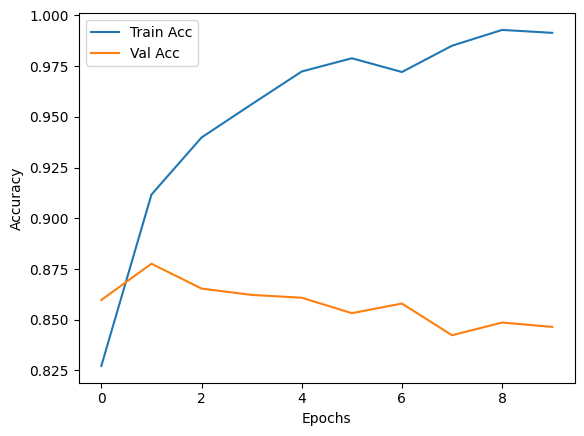

In [32]:
#  Training Curves
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      4961
    Positive       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



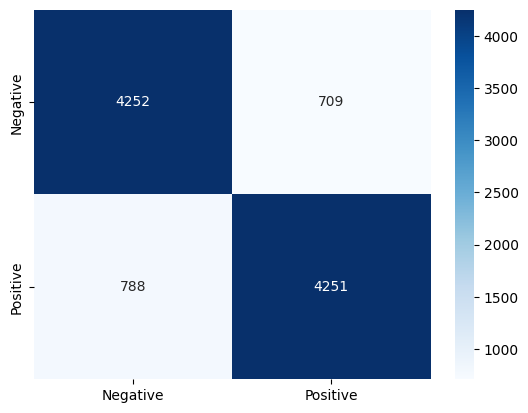

In [33]:
# Classification Report

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Negative","Positive"]))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.show()

In [34]:
# Try a custom review prediction
def predict_review(review):
  # Clean the text
  text = review.lower()
  text = re.sub(r'[^a-z\s]','',text)

  # Convert to Sequence
  seq = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(seq,maxlen=max_len)

  #Predict
  pred = model.predict(padded)[0][0]
  label = "Positive 😀" if pred > 0.5 else "Negative 😞"
  print(f"Review: {review}\nPrediction: {label} (score={pred:.2f})")

# Example
predict_review("The movie was fantastic, I really enjoyed it!")
predict_review("The movie was terrible and boring.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Review: The movie was fantastic, I really enjoyed it!
Prediction: Positive 😀 (score=0.91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Review: The movie was terrible and boring.
Prediction: Negative 😞 (score=0.00)
